# Test model on various samples

In [96]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from math import log2, floor
from random import randint

from obb.model.custom_model import *
from obb.utils.dataset import *
from obb.utils.polygon import *

# set plot deafult values
plt.matplotlib.rc('grid', linestyle = 'dotted', linewidth=1.5, alpha = 0.25)
plt.matplotlib.rc('font', family='serif', size=11)
plt.matplotlib.rc('legend', fontsize=11)

# Change ticks
plt.rcParams['xtick.major.size'] = 7.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.major.size'] = 7.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['ytick.direction'] = 'inout'
colors = ['#0051a2', '#97964a', '#ffd44f', '#f4777f', '#ad8966', ]

C:\Users\matan\AppData\Local\Temp/ipykernel_22648/1607484070.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


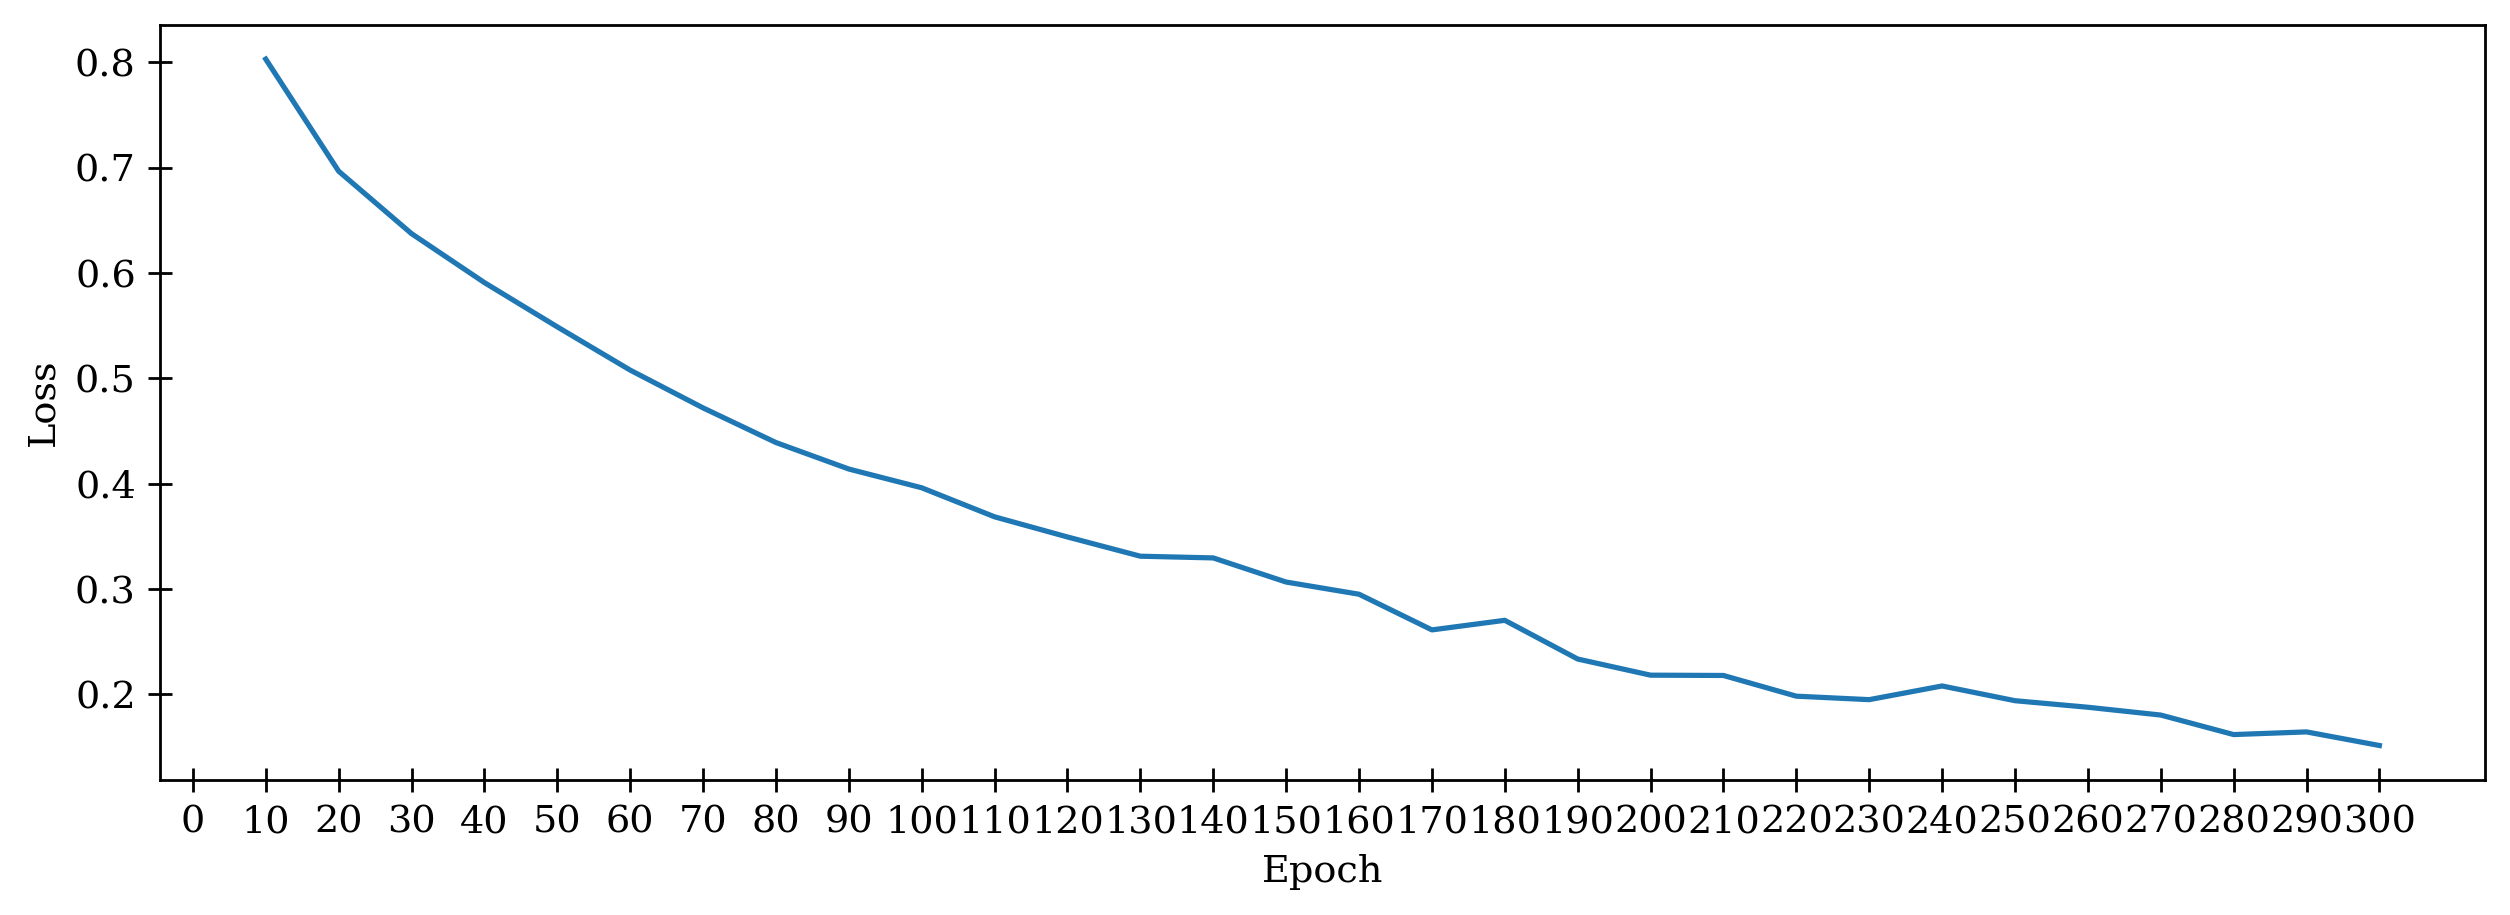

In [125]:
# Plot training loss
num_epochs = 300
epoch_step = 10

loss_lst = []

for epoch in range(epoch_step, num_epochs + epoch_step, epoch_step):
    checkpoint = torch.load(f'../src/obb/model/checkpoints_sample/epoch_{epoch}.pt', map_location=torch.device('cpu'))
    loss_lst.append(checkpoint['loss'])

fig = plt.figure(figsize=(12, 4), dpi=250)
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(epoch_step, num_epochs + epoch_step, epoch_step), loss_lst)
ax.set_xticks(range(0, num_epochs + epoch_step, epoch_step))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()

In [126]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

epoch = 300  # Most recent epoch

# Load trained weights to detector
checkpoint = torch.load(f'../src/obb/model/checkpoints_sample/epoch_{epoch}.pt', map_location=torch.device('cpu'))
model = DetectionModel().to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

Using cache found in C:\Users\matan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-4-24 torch 1.10.0+cpu CPU

Fusing layers... 
Model summary: 290 layers, 21640929 parameters, 0 gradients
Adding AutoShape... 


DetectionModel(
  (feature_map): YOLOv5Features(
    (features): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 48, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): 

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


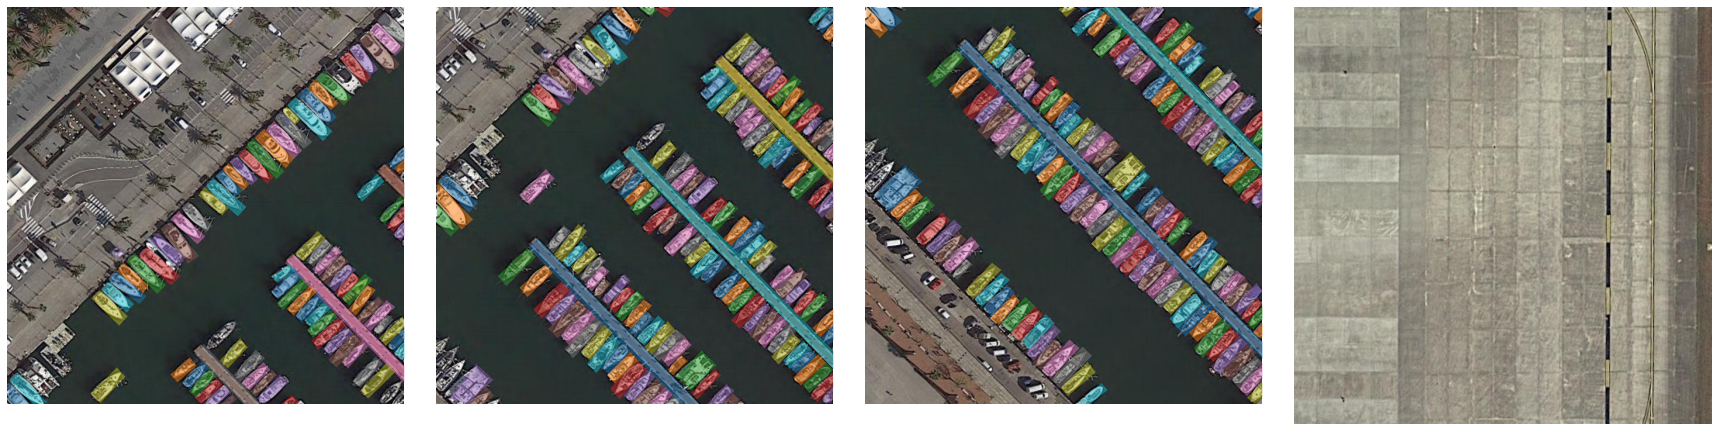

In [90]:
# Load sample dataset
train_dataset = Dataset(path='../assets/DOTA_sample_data/split')
train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

fig = plt.figure(figsize=(24, 8))
num_imgs = len(train_data_loader)
for idx, (img, obb, object_class) in enumerate(train_data_loader):
    img = img.to(device)
    obb = obb.squeeze(dim=0)
    print(img.shape)
    ax = fig.add_subplot(1, len(train_data_loader), idx + 1)
    ax.imshow(img.squeeze().permute(1, 2, 0).numpy())
    for bbox in obb:
        bbox = bbox.reshape(-1, 2)
        ax.fill(bbox[:, 0].detach().numpy(), bbox[:, 1].detach().numpy(), alpha=0.5);
    ax.set_axis_off()

plt.tight_layout()

Feeding image #1...
Feeding image #2...
Feeding image #3...
Feeding image #4...


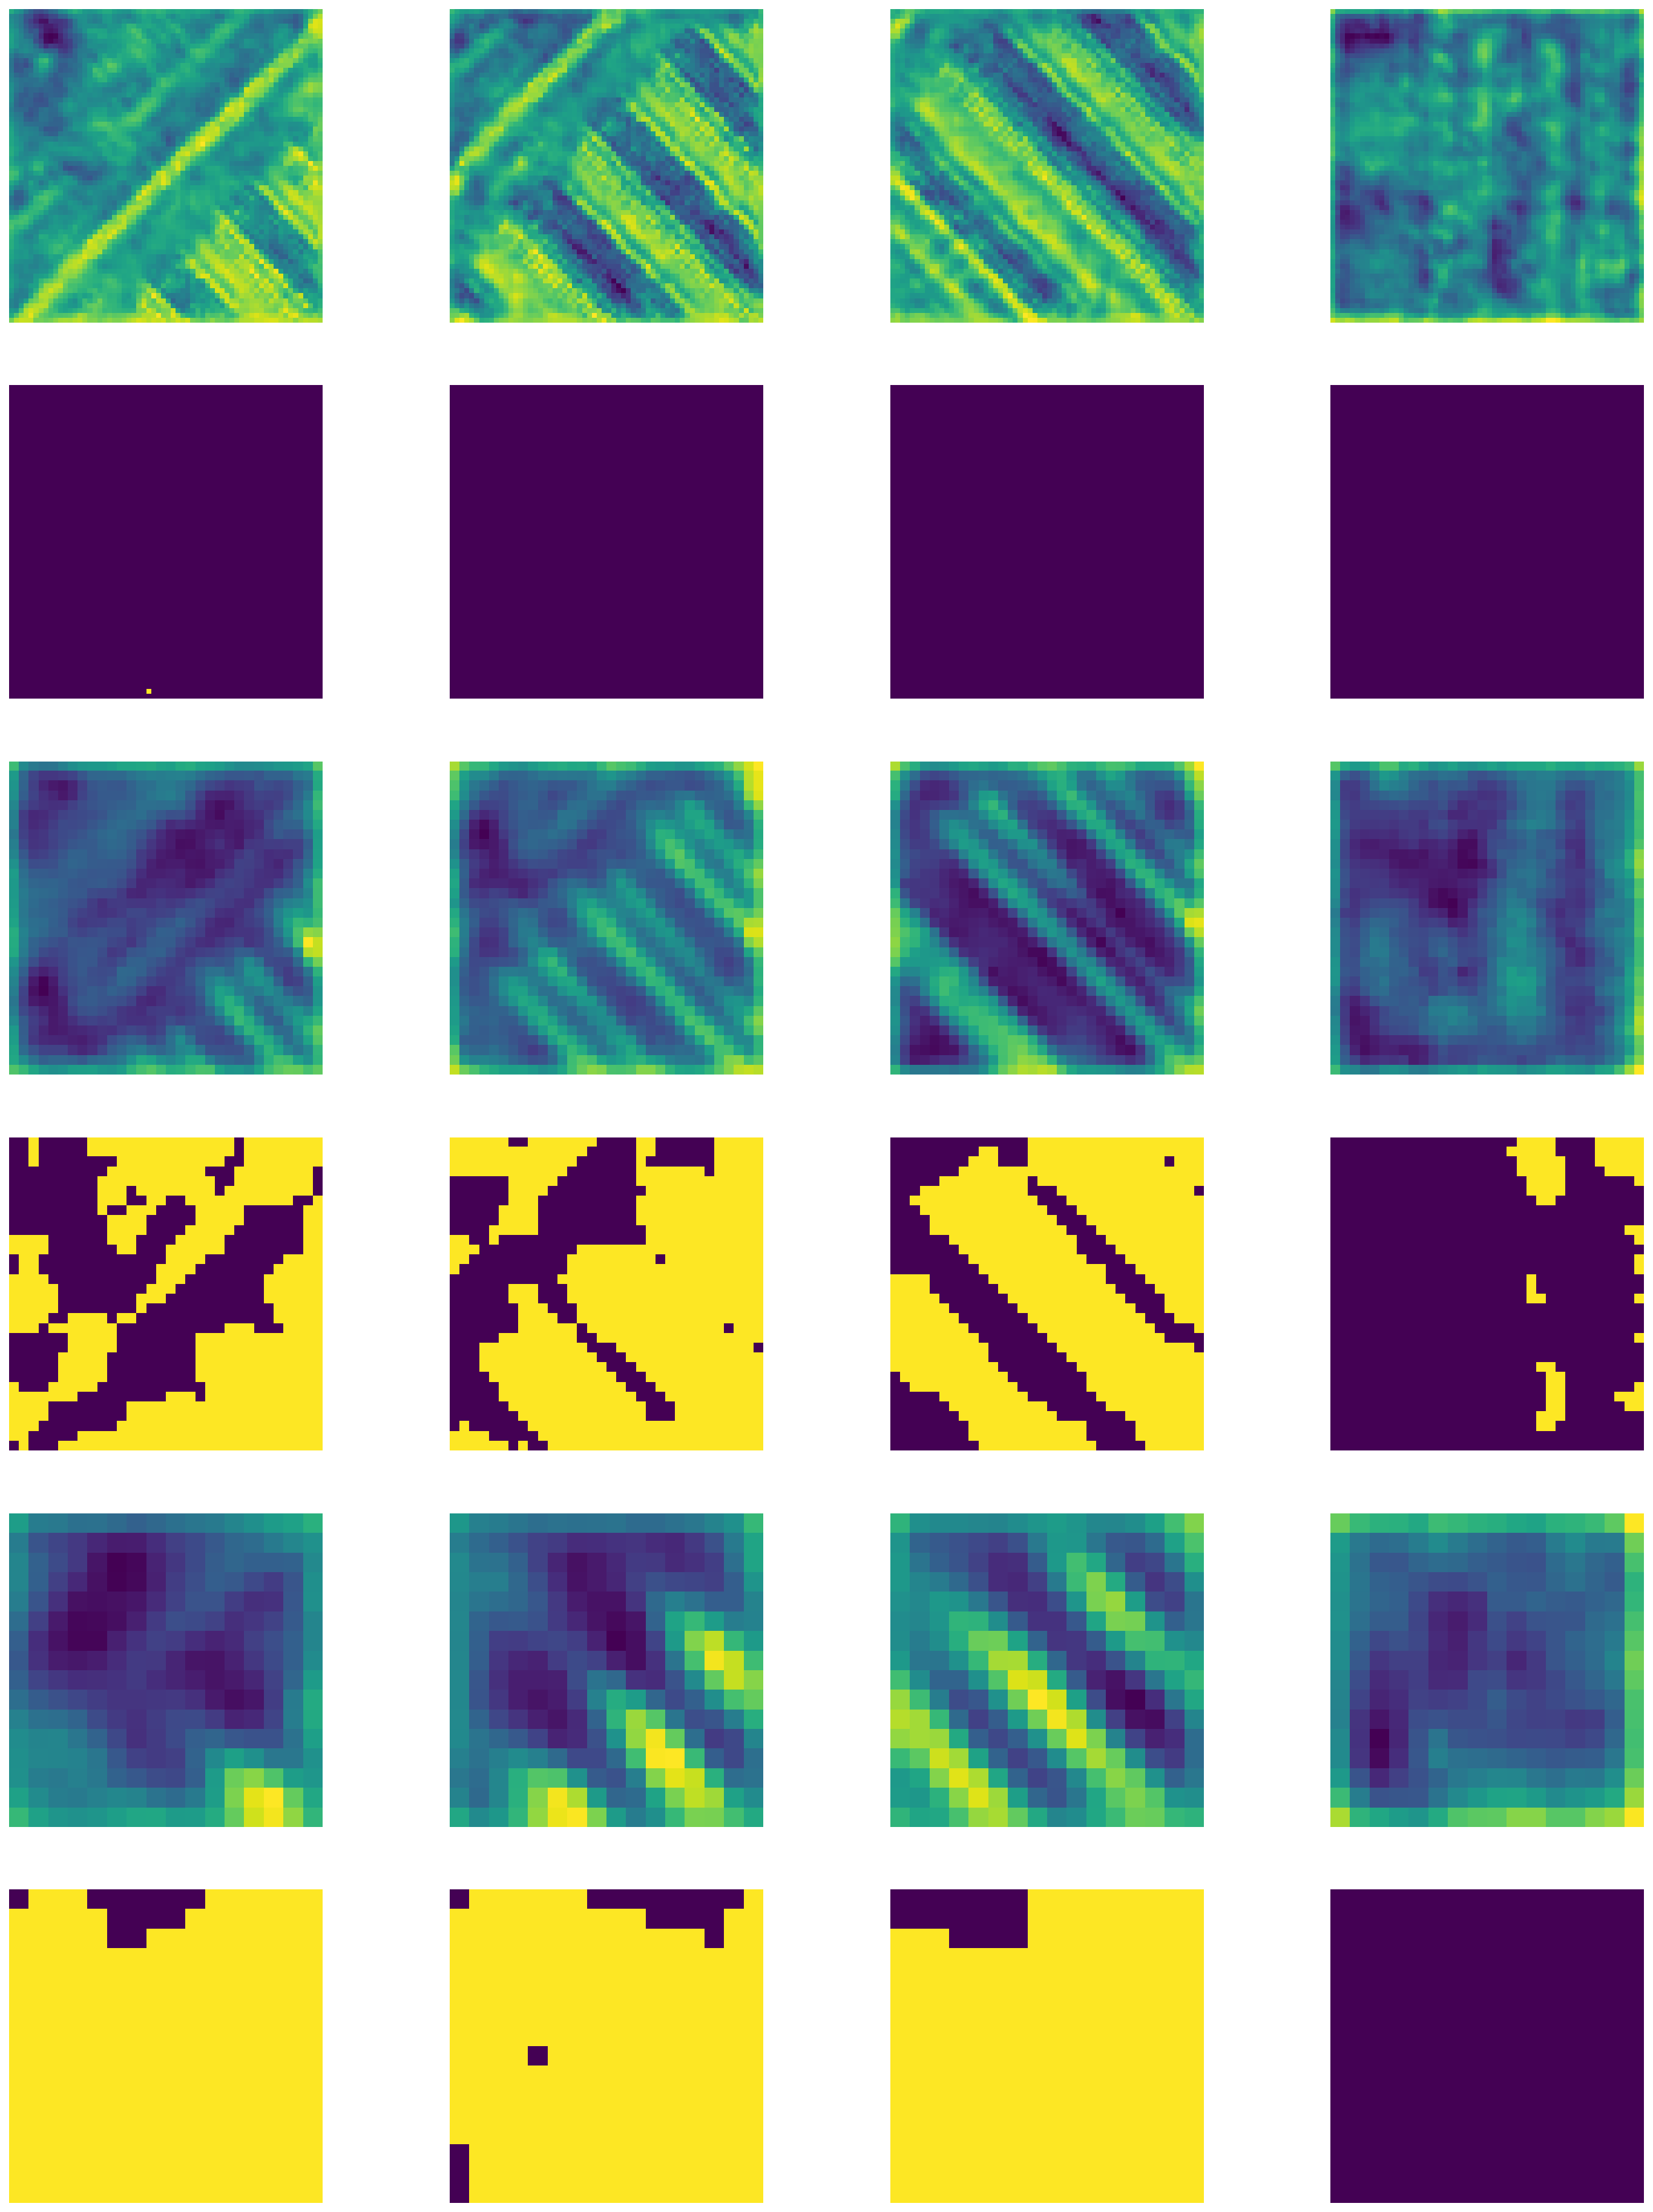

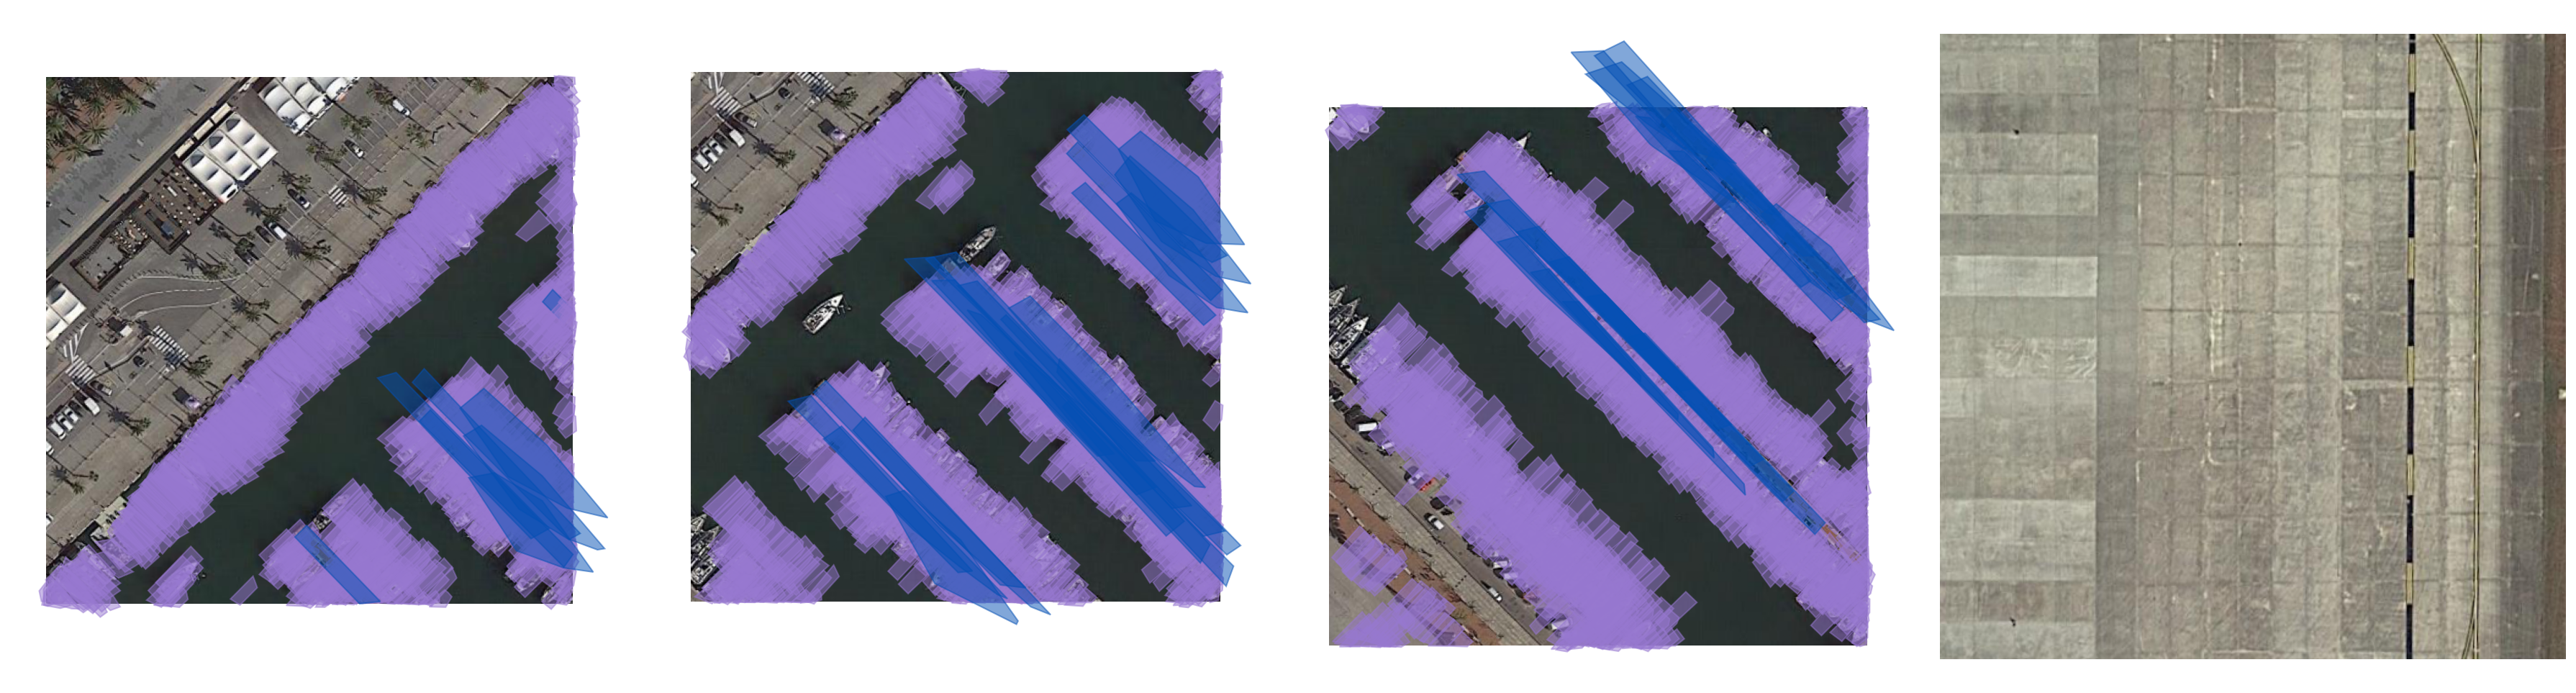

In [132]:
colors = []

for i in range(1, 16):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

# Classification thresholds
threshold_dict = {
    'P3': 0.4,
    'P4': 0.4,
    'P5': 0.4
}

# Get feature maps
fig = plt.figure(figsize=(24, 32), dpi=150)
fig1 = plt.figure(figsize=(24, 8), dpi=150)
for idx, (img, obb, object_class) in enumerate(train_data_loader):
    print(f'Feeding image #{idx+1}...')

    img = img.to(device)
    obb = obb.squeeze(dim=0)
    object_class = object_class.squeeze(dim=0)

    try:
        rep_points_init, rep_points_refine, classification = model(img)
    except:
        print('Error')
        continue

    num_lvls = len(classification.keys())
    for lvl_idx, lvl in enumerate(classification.keys()):
        # Get objectness, classification and RepPoints
        obj, cls = classification[lvl][0, 0], classification[lvl][0, 1:]

        # Confidence
        ax = fig.add_subplot(2 * num_lvls, len(train_data_loader), 2 * num_imgs * lvl_idx + idx + 1)
        obj_map = ax.imshow(obj.detach().numpy())
        ax.set_axis_off()
        # plt.colorbar(obj_map)

        # Classification
        ax = fig.add_subplot(2 * num_lvls, len(train_data_loader), 2 * num_imgs * lvl_idx + idx + 1 + num_imgs)
        class_map = ax.imshow(torch.argmax(cls, dim=0).detach().numpy() + 1)
        ax.set_axis_off()
        # plt.colorbar(class_map, ticks=range(0, 16))

    # Localization
    ax = fig1.add_subplot(1, len(train_data_loader), idx + 1)
    ax.imshow(img.squeeze().permute(1, 2, 0).numpy())
    ax.set_axis_off()
    for lvl_idx, lvl in enumerate(classification.keys()):
        obj, cls, pts = torch.sigmoid(classification[lvl][0, 0]), classification[lvl][0, 1:], rep_points_refine[lvl][0]
        cls_hard = torch.argmax(cls, dim=0).to(int) + 1
        for i in range(pts.shape[1]):
            for j in range(pts.shape[2]):
                pt_set = pts[:, i, j].reshape(-1, 2)
                if obj[i, j] > threshold_dict[lvl]:
                    hull = convex_hull(pt_set)
                    # ax.scatter(pt_set[:, 0].detach().numpy(), pt_set[:, 1].detach().numpy(), s=2)
                    ax.fill(hull[:, 0].detach().numpy(), hull[:, 1].detach().numpy(), alpha=0.5, color=colors[cls_hard[i, j]])

plt.tight_layout()